Omid Jafaei 401204268

Answer of Theoretical Questions:

1. In a "normal" convolutional network, the sampling locations are fixed and follow a regular grid pattern. On the other hand, in a "deformable" convolutional network, the grid sampling locations are adaptively adjusted according to the objects' scale and shape. This adaptive adjustment is achieved by adding 2D offsets to the regular grid sampling locations, enabling free-form deformation of the sampling grid. These offsets are learned from the preceding feature maps, allowing for local, dense, and adaptive transformations.

2. By adding 2D offsets to the regular grid sampling locations, deformable convolution enables adaptive adjustment of the sampling locations according to the objects' scale and shape. Also, de-formable RoI pooling adds an offset to each bin position in the regular bin partition of the previous RoI pooling, allowing for adaptive part localization for objects with different shapes. Overall, de-formable networks create flexibility in geometric transformation in images by introducing adaptive and learnable mechanisms for adjusting sampling locations and part localization, enabling the net-work to better capture and model complex spatial transformations in the input data.

3. This is due to the fixed geometric structures in their building modules, which restrict their ability to effectively model complex geometric transformations.

4. The offsets are obtained by applying additional convolutional layers over the input feature map. These convolutional layers are responsible for learning the adjustments to the regular grid sampling locations based on the preceding feature maps.


Implementaions:

In [ ]:
!mkdir /content/ms_coco
!wget http://images.cocodataset.org/zips/train2017.zip
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip train2017.zip -d /content/ms_coco
!unzip annotations_trainval2017.zip -d /content/ms_coco

In [2]:
!ls /content/ms_coco

annotations  train2017


In [3]:
import torch
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor, Resize, Compose
from torch.utils.data import DataLoader
from torch.nn.functional import pad
from tqdm import tqdm
import torch
from torch import nn
import torchvision.ops
from torch.optim import Adam
from torchvision.transforms import Compose, ToTensor, CenterCrop
from torch.utils.data import random_split
import matplotlib.pyplot as plt
import time
data_root = '/content/ms_coco'
image_folder = 'train2017'
annotation_file = 'annotations/instances_train2017.json'

transform = Compose([Resize((400, 400)), ToTensor()])

coco_dataset = CocoDetection(root=f'{data_root}/{image_folder}',
                             annFile=f'{data_root}/{annotation_file}',
                             transform=transform)

def custom_collate(batch):
    max_height = max(img.shape[1] for img, _ in batch)
    max_width = max(img.shape[2] for img, _ in batch)
    resized_batch = [
        pad(img, (0, max_width - img.shape[2], 0, max_height - img.shape[1]), value=0)
        for img, _ in batch
    ]
    stacked_images = torch.stack(resized_batch)
    targets = [target for _, target in batch]

    return stacked_images, targets

total_size = len(coco_dataset)
train_size = 20000
test_size = 2000
redundant = total_size - train_size - test_size


train_dataset, test_dataset, redundant_dataset = random_split(coco_dataset, [train_size, test_size, redundant])
batch_size = 32
torch.manual_seed(97)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, collate_fn=custom_collate)

loading annotations into memory...
Done (t=20.03s)
creating index...
index created!


In [4]:
class classifier(nn.Module):
  def __init__(self):
    super(classifier,self).__init__()

    self.block1=nn.Sequential(nn.Conv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride = 2, padding = 0, bias = False),
                              nn.BatchNorm2d(num_features = 16),
                              nn.MaxPool2d(kernel_size = 5, stride = 2, padding = 1),
                              nn.ReLU(),
                              nn.Dropout(0.3)
                              )
    self.block2=nn.Sequential(nn.Conv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 2, padding = 0, bias = False),
                              nn.BatchNorm2d(num_features = 32),
                              nn.MaxPool2d(kernel_size = 5, stride = 2, padding = 1),
                              nn.ReLU(),
                              nn.Dropout(0.2)
                              )
    self.block3=nn.Sequential(nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 2, padding = 0, bias = False),
                              nn.BatchNorm2d(num_features = 64),
                              nn.MaxPool2d(kernel_size = 5, stride = 2, padding = 1),
                              nn.ReLU(),
                              nn.Dropout(0.1)
                              )

    self.fc = nn.Linear(in_features=self.get_output(), out_features=2)
    self.softmax = nn.Softmax(dim = 1)

  def get_output(self):
    dummy_input = torch.randn([1, 3, 400, 400])
    output = self.block1(dummy_input)
    output = self.block2(output)
    output = self.block3(output)
    flatten_output = torch.flatten(output, start_dim = 1)
    return flatten_output.shape[1]


  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = torch.flatten(x, start_dim = 1)
    x = self.fc(x)

    return x


In [5]:
class DeformableConv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size=3,
                 stride=1,
                 padding=1,
                 dilation=1,
                 bias=False):
        super(DeformableConv2d, self).__init__()

        assert type(kernel_size) == tuple or type(kernel_size) == int

        kernel_size = kernel_size if type(kernel_size) == tuple else (kernel_size, kernel_size)
        self.stride = stride if type(stride) == tuple else (stride, stride)
        self.padding = padding
        self.dilation = dilation

        self.offset_conv = nn.Conv2d(in_channels,
                                     2 * kernel_size[0] * kernel_size[1],
                                     kernel_size=kernel_size,
                                     stride=stride,
                                     padding=self.padding,
                                     dilation=self.dilation,
                                     bias=True)

        nn.init.constant_(self.offset_conv.weight, 0.)
        nn.init.constant_(self.offset_conv.bias, 0.)

        self.modulator_conv = nn.Conv2d(in_channels,
                                        1 * kernel_size[0] * kernel_size[1],
                                        kernel_size=kernel_size,
                                        stride=stride,
                                        padding=self.padding,
                                        dilation=self.dilation,
                                        bias=True)

        nn.init.constant_(self.modulator_conv.weight, 0.)
        nn.init.constant_(self.modulator_conv.bias, 0.)

        self.regular_conv = nn.Conv2d(in_channels=in_channels,
                                      out_channels=out_channels,
                                      kernel_size=kernel_size,
                                      stride=stride,
                                      padding=self.padding,
                                      dilation=self.dilation,
                                      bias=bias)

    def forward(self, x):
        offset = self.offset_conv(x)
        modulator = 2. * torch.sigmoid(self.modulator_conv(x))
        x = torchvision.ops.deform_conv2d(input=x,
                                          offset=offset,
                                          weight=self.regular_conv.weight,
                                          bias=self.regular_conv.bias,
                                          padding=self.padding,
                                          mask=modulator,
                                          stride=self.stride,
                                          dilation=self.dilation)
        return x

In [6]:
class classifier_deform(nn.Module):
  def __init__(self):
    super(classifier_deform,self).__init__()

    self.block1=nn.Sequential(DeformableConv2d(in_channels = 3, out_channels = 16, kernel_size = 5, stride = 2, padding = 0, bias = False),
                              nn.BatchNorm2d(num_features = 16),
                              nn.MaxPool2d(kernel_size = 5, stride = 2, padding = 1),
                              nn.ReLU(),
                              nn.Dropout(0.3)
                              )
    self.block2=nn.Sequential(DeformableConv2d(in_channels = 16, out_channels = 32, kernel_size = 5, stride = 2, padding = 0, bias = False),
                              nn.BatchNorm2d(num_features = 32),
                              nn.MaxPool2d(kernel_size = 5, stride = 2, padding = 1),
                              nn.ReLU(),
                              nn.Dropout(0.2)
                              )
    self.block3=nn.Sequential(DeformableConv2d(in_channels = 32, out_channels = 64, kernel_size = 5, stride = 2, padding = 0, bias = False),
                              nn.BatchNorm2d(num_features = 64),
                              nn.MaxPool2d(kernel_size = 5, stride = 2, padding = 1),
                              nn.ReLU(),
                              nn.Dropout(0.1)
                              )

    self.fc = nn.Linear(in_features=self.get_output(), out_features=2)
    self.softmax = nn.Softmax(dim = 1)

  def get_output(self):
    dummy_input = torch.randn([1, 3, 400, 400])
    output = self.block1(dummy_input)
    output = self.block2(output)
    output = self.block3(output)
    flatten_output = torch.flatten(output, start_dim = 1)
    return flatten_output.shape[1]


  def forward(self, x):
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = torch.flatten(x, start_dim = 1)
    x = self.fc(x)

    return x

In [7]:
def get_person_labels(target_dicts):
    batch_size = len(target_dicts)
    y=torch.zeros(batch_size)
    for i in range(0,batch_size):
        for j in range(0, len(target_dicts[i])):
            if target_dicts[i][j]['category_id'] == 1:
              y[i]=1
              break
    return y

#Normal Conv.

In [ ]:
epochs = 20
Loss_train=[]
acc_list = []
err_list = []
device = "cuda" if torch.cuda.is_available() else "cpu"
tic = time.time()
model1=classifier()
model1 = model1.to(device)
citeration = nn.CrossEntropyLoss()
optimizer= Adam(model1.parameters(), lr = 1e-3)
for epoch in range(epochs):
    batch_loss = []
    batch_acc = []
    model1.train()
    with tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}', unit='batch', leave=False) as epoch_progress:
        for batch_idx, (images, targets) in enumerate(epoch_progress):
            y = get_person_labels(targets)
            x, y = images.to(device), y.to(device)
            y_pred = model1(x)
            y = y.to(torch.long)
            loss = citeration(y_pred.to(device), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            softmax = nn.Softmax(dim=1)
            batch_loss.append(citeration(softmax(y_pred).to(device), y))
            _ , preds = torch.max(softmax(y_pred), 1)
            correct_counts = preds.eq(y.view_as(preds))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            batch_acc.append(acc)
        Loss_train.append(float(sum(batch_loss)/len(batch_loss)))
        acc_list.append(float(sum(batch_acc)/len(batch_acc)))
toc = time.time()

In [ ]:
training_time =  (toc-tic)/3600
print('Training Time (hr.):', training_time)

Training Time (hr.): 1.3689459198713303


In [ ]:
%matplotlib inline
err_list = [1-x for x in acc_list]
plt.plot(err_list, 'o')
plt.title('Error on Different Epochs')
plt.xticks(range(1, 1+epochs))
plt.show();

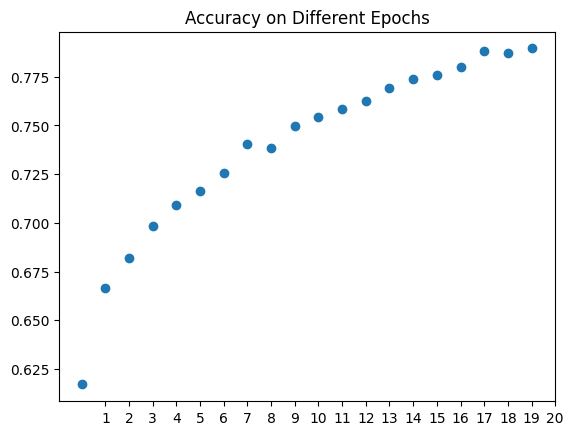

In [ ]:
%matplotlib inline
plt.plot(acc_list, 'o')
plt.title('Accuracy on Different Epochs')
plt.xticks(range(1, 1+epochs))
plt.show();

In [ ]:
model1.eval()
test_acc=[]
test_batch_acc=[]
for batch_idx, (a1 ,b2 ) in enumerate(test_loader):
    b1 = get_person_labels(b2)
    yyy = model1(a1.to(device))
    _ , preds = torch.max(yyy, 1)
    b1 = b1.to(device)
    correct_counts = preds.eq(b1)
    acc = torch.mean(correct_counts.type(torch.FloatTensor))
    test_acc.append(acc)
test_acc = float(sum(test_acc)/len(test_acc))
print('Test Accuracy: ', test_acc)
print('Test Error: ', 1-test_acc)

Test Accuracy:  0.6830357313156128
Test Error:  0.3169642686843872

#Deformable Conv.

In [8]:
epochs = 20
Loss_train=[]
acc_list = []
err_list = []
device = "cuda" if torch.cuda.is_available() else "cpu"
tic = time.time()
model2=classifier_deform()
model2 = model2.to(device)
citeration = nn.CrossEntropyLoss()
optimizer= Adam(model2.parameters(), lr = 1e-3)
for epoch in range(epochs):
    batch_loss = []
    batch_acc = []
    model2.train()
    with tqdm(train_loader, desc=f'Epoch {epoch}/{epochs}', unit='batch', leave=False) as epoch_progress:
        for batch_idx, (images, targets) in enumerate(epoch_progress):
            y = get_person_labels(targets)
            x, y = images.to(device), y.to(device)
            y_pred = model2(x)
            y = y.to(torch.long)
            loss = citeration(y_pred.to(device), y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            softmax = nn.Softmax(dim=1)
            batch_loss.append(citeration(softmax(y_pred).to(device), y))
            _ , preds = torch.max(softmax(y_pred), 1)
            correct_counts = preds.eq(y.view_as(preds))
            acc = torch.mean(correct_counts.type(torch.FloatTensor))
            batch_acc.append(acc)
        Loss_train.append(float(sum(batch_loss)/len(batch_loss)))
        acc_list.append(float(sum(batch_acc)/len(batch_acc)))
toc = time.time()

In [11]:
training_time =  (toc-tic)/3600
print('Training Time (hr.):', training_time)

Training Time (hr.): 1.871632892092069


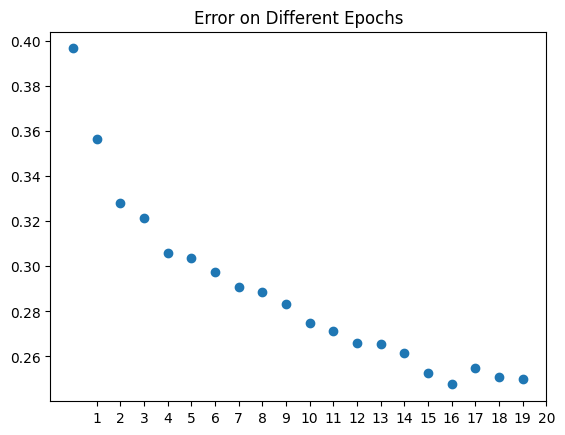

In [12]:
%matplotlib inline
err_list = [1-x for x in acc_list]
plt.plot(err_list, 'o')
plt.title('Error on Different Epochs')
plt.xticks(range(1, 1+epochs))
plt.show();

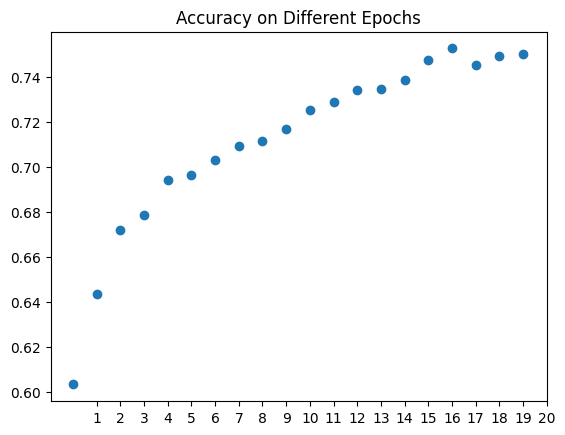

In [13]:
%matplotlib inline
plt.plot(acc_list, 'o')
plt.title('Accuracy on Different Epochs')
plt.xticks(range(1, 1+epochs))
plt.show();

In [14]:
model2.eval()
test_acc=[]
test_batch_acc=[]
for batch_idx, (a1 ,b2 ) in enumerate(test_loader):
    b1 = get_person_labels(b2)
    yyy = model2(a1.to(device))
    _ , preds = torch.max(yyy, 1)
    b1 = b1.to(device)
    correct_counts = preds.eq(b1)
    acc = torch.mean(correct_counts.type(torch.FloatTensor))
    test_acc.append(acc)
test_acc = float(sum(test_acc)/len(test_acc))
print('Test Accuracy: ', test_acc)
print('Test Error: ', 1-test_acc)

Test Accuracy:  0.7415674328804016
Test Error:  0.2584325671195984


در ازای زمان بیشتر اجرا خطای ی تست بهبود نسبت خوبی یافته است.
برای حالت معمولی دقت حدود 0.68 بود.

کلاس DeformableConv2d
از ریپازیتوری زیر برداشته شده است.
https://github.com/developer0hye/PyTorch-Deformable-Convolution-v2/blob/main/dcn.py